# Creación de la base de datos e inserción de información proveniente del dataset

In [1]:
import pandas as pd
import sqlite3

In [2]:
# Leer CSV
df = pd.read_csv('/content/drive/MyDrive/Data Science EBAC/Datasets Colab/Cientifico de datos M41 recursos_humanos.csv')

# Mostrar las primeras filas para verificar
print(df.head())

   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years  sales  \
0                   3              0     1                      0  sales   
1                   6              0     1                      0  sales   
2                   4              0     1                      0  sales   
3                   5              0     1                      0  sales   
4                   3              0     1                      0  sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4 

In [3]:
# Crear conexión y base de datos
conn = sqlite3.connect('RH.db')
cursor = conn.cursor()

In [4]:
# Crear tabla Detalle con columnas y tipos
cursor.execute('''
CREATE TABLE IF NOT EXISTS Detalle (
    satisfaction_level REAL,
    last_evaluation REAL,
    number_project INTEGER,
    average_montly_hours INTEGER,
    time_spend_company INTEGER,
    Work_accident INTEGER,
    left INTEGER,
    promotion_last_5years INTEGER,
    sales TEXT,
    salary TEXT
)
''')
conn.commit()

In [5]:
# Insertar datos del dataframe en la tabla Detalle
df.to_sql('Detalle', conn, if_exists='replace', index=False)

14999

In [6]:
# Verificar que la tabla se creó y tiene datos
cursor.execute('SELECT COUNT(*) FROM Detalle')
print(f"Filas insertadas: {cursor.fetchone()[0]}")

conn.close()

Filas insertadas: 14999


# Consultas a la base de datos creada

1. Nivel de satisfacción promedio más alto entre empleados que se van (left=1) y los que se quedan (left=0):

In [7]:
conn = sqlite3.connect('RH.db')
cursor = conn.cursor()

query = '''
SELECT left, AVG(satisfaction_level) as promedio_satisfaccion
FROM Detalle
GROUP BY left
'''

cursor.execute(query)
result = cursor.fetchall()

for row in result:
    estado = 'Se fue' if row[0] == 1 else 'Se quedó'
    print(f"{estado}: nivel de satisfacción promedio = {row[1]:.4f}")

conn.close()

Se quedó: nivel de satisfacción promedio = 0.6668
Se fue: nivel de satisfacción promedio = 0.4401


2. Número promedio de horas de trabajo para empleados con salario bajo o medio:

In [8]:
conn = sqlite3.connect('RH.db')
cursor = conn.cursor()

query = '''
SELECT AVG(average_montly_hours) as promedio_horas
FROM Detalle
WHERE salary IN ('low', 'medium')
'''

cursor.execute(query)
resultado = cursor.fetchone()

print(f"Promedio de horas mensuales (salario bajo o medio): {resultado[0]:.2f}")

conn.close()

Promedio de horas mensuales (salario bajo o medio): 201.16


3. Empleados que recibieron promoción en los últimos 5 años y abandonaron la empresa:

In [9]:
conn = sqlite3.connect('RH.db')

query = '''
SELECT *
FROM Detalle
WHERE promotion_last_5years = 1
AND left = 1
'''

df_promocion_left = pd.read_sql_query(query, conn)
print(f"Cantidad de empleados promocionados y que se fueron: {len(df_promocion_left)}")
display(df_promocion_left.head())

conn.close()

Cantidad de empleados promocionados y que se fueron: 19


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.45,0.51,2,160,3,1,1,1,sales,low
1,0.79,0.59,4,139,3,0,1,1,management,low
2,0.41,0.46,2,160,3,0,1,1,sales,low
3,0.11,0.79,6,292,4,0,1,1,technical,low
4,0.41,0.56,2,154,3,0,1,1,support,medium


4. Empleados con calificación en última evaluación de 0.9 o más:

In [10]:
conn = sqlite3.connect('RH.db')

query = '''
SELECT *
FROM Detalle
WHERE last_evaluation >= 0.9
'''

df_evaluacion_alta = pd.read_sql_query(query, conn)
print(f"Cantidad de empleados con evaluación >= 0.9: {len(df_evaluacion_alta)}")
display(df_evaluacion_alta.head())

conn.close()

Cantidad de empleados con evaluación >= 0.9: 2988


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.89,1.00,5,224,5,0,1,0,sales,low
1,0.84,0.92,4,234,5,0,1,0,sales,low
2,0.78,0.99,4,255,6,0,1,0,sales,low
3,0.09,0.95,6,304,4,0,1,0,sales,low
4,0.89,0.92,5,242,5,0,1,0,sales,low


# Visualizaciones

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Abrir conexión
conn = sqlite3.connect('RH.db')

/tmp/ipython-input-3217244148.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_satisfaccion, x='Estado', y='promedio_satisfaccion', palette='viridis')


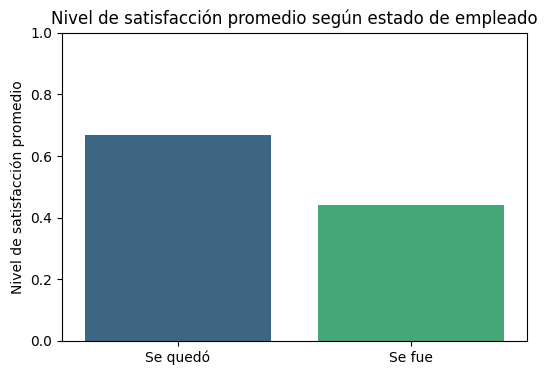

In [14]:
# Nivel de satisfacción promedio según si se fue o se quedó
query_satisfaccion = '''
SELECT left, AVG(satisfaction_level) as promedio_satisfaccion
FROM Detalle
GROUP BY left
'''
df_satisfaccion = pd.read_sql_query(query_satisfaccion, conn)
df_satisfaccion['Estado'] = df_satisfaccion['left'].map({0: 'Se quedó', 1: 'Se fue'})

plt.figure(figsize=(6,4))
sns.barplot(data=df_satisfaccion, x='Estado', y='promedio_satisfaccion', palette='viridis')
plt.title('Nivel de satisfacción promedio según estado de empleado')
plt.ylabel('Nivel de satisfacción promedio')
plt.xlabel('')
plt.ylim(0,1)
plt.show()

/tmp/ipython-input-3510175258.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_horas, x='salary', y='promedio_horas', palette='magma')


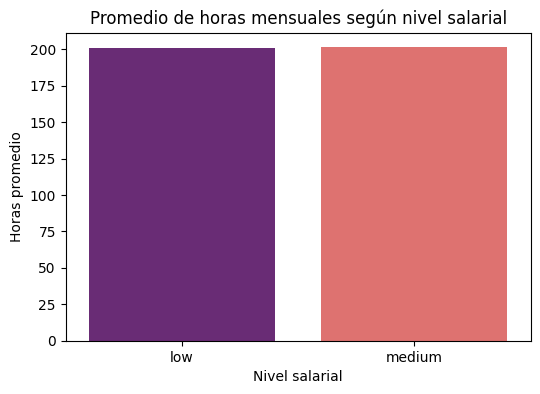

In [15]:
# Promedio de horas trabajadas para salarios low y medium (ya es un solo valor)
query_horas = '''
SELECT AVG(average_montly_hours) as promedio_horas, salary
FROM Detalle
WHERE salary IN ('low', 'medium')
GROUP BY salary
'''
df_horas = pd.read_sql_query(query_horas, conn)

plt.figure(figsize=(6,4))
sns.barplot(data=df_horas, x='salary', y='promedio_horas', palette='magma')
plt.title('Promedio de horas mensuales según nivel salarial')
plt.ylabel('Horas promedio')
plt.xlabel('Nivel salarial')
plt.show()

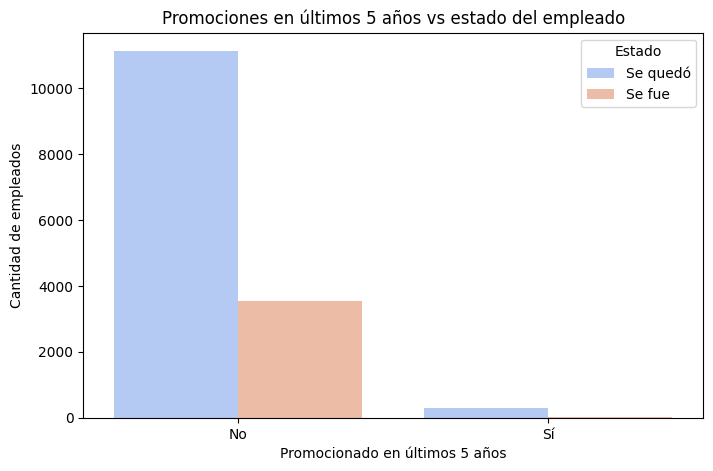

In [16]:
# Distribución de promociones en últimos 5 años entre los que se fueron y se quedaron
query_promocion = '''
SELECT promotion_last_5years, left, COUNT(*) as cantidad
FROM Detalle
GROUP BY promotion_last_5years, left
'''
df_promocion = pd.read_sql_query(query_promocion, conn)
df_promocion['Estado'] = df_promocion['left'].map({0: 'Se quedó', 1: 'Se fue'})
df_promocion['Promocionado'] = df_promocion['promotion_last_5years'].map({0: 'No', 1: 'Sí'})

plt.figure(figsize=(8,5))
sns.barplot(data=df_promocion, x='Promocionado', y='cantidad', hue='Estado', palette='coolwarm')
plt.title('Promociones en últimos 5 años vs estado del empleado')
plt.ylabel('Cantidad de empleados')
plt.xlabel('Promocionado en últimos 5 años')
plt.show()

conn.close()